In [1]:
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_ellipses_exp2Q(
    r, Qxx, Qxy, L=None, idx=None,
    draw_director=True, color_by_s=False, ax=None, lw=1.0, alpha=1.0,
s_min = None, s_max=None, x_min = None, x_max =None, y_min = None, y_max=None):
    """
    Plot ellipses for Σ = exp(2Q) with Q = [[Qxx,Qxy],[Qxy,-Qxx]] (unit determinant).
    The ellipse is the contour x^T Σ^{-1} x = 1, i.e. semi-axes a=e^{+s}, b=e^{-s},
    orientation θ = 0.5*atan2(Qxy, Qxx), with s = sqrt(Qxx^2 + Qxy^2).

    Args:
      r  : (N,2) centers
      Qxx,Qxy : (N,) arrays
      L  : box size (optional; sets x/y limits to [0,L])
      idx: indices to plot (optional subsample). If None, plots all.
      draw_director: draw a small line along director angle
      color_by_s: color ellipses by s magnitude
      ax : matplotlib Axes (optional)
      lw, alpha : line width and alpha for ellipses
    """
    r = np.asarray(r)
    Qxx = np.asarray(Qxx)
    Qxy = np.asarray(Qxy)
    N = len(Qxx)
    if idx is None:
        idx = np.arange(N)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    # spectral data
    s = np.sqrt(Qxx*Qxx + Qxy*Qxy)
    theta = 0.5 * np.arctan2(Qxy, Qxx)        # radians
    a = np.exp(+s)                             # semi-major
    b = np.exp(-s)                             # semi-minor
    ang_deg = np.degrees(theta)

    if color_by_s:
        # normalize s for colormap
        sm = plt.cm.ScalarMappable(cmap='viridis')
        s_plot = s[idx]
        if(s_min is None or s_max is  None):
            cmin, cmax = (s_plot.min(), s_plot.max()) if s_plot.size else (0,1)
            sm.set_clim(cmin, cmax)
        else:
            sm.set_clim(s_min, s_max)
        colors = sm.to_rgba(s[idx])
    else:
        colors = None

    for k_i, k in enumerate(idx):
        e = Ellipse(
            xy=(r[k,0], r[k,1]),
            width=2*a[k], height=2*b[k],
            angle=ang_deg[k], fill=False,
            linewidth=lw,
            alpha=alpha,
            edgecolor=(colors[k_i] if color_by_s else 'k')
        )
        ax.add_patch(e)

    if draw_director and len(idx) > 0:
        seg_len = 0.6
        ux = np.cos(theta[idx]); uy = np.sin(theta[idx])
        ax.quiver(r[idx,0], r[idx,1], ux, uy,
                  angles='xy', scale_units='xy', scale=1/seg_len,
                  width=0.003, headwidth=0, color='k', alpha=alpha)

    if L is not None:
        ax.set_xlim(0, L); ax.set_ylim(0, L)
    elif x_min is not None and x_max is not None and y_min is not None and y_max is not None:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        # a little padding
        mins = r[idx].min(axis=0); maxs = r[idx].max(axis=0)
        pad = 0.05*(maxs - mins + 1e-9)
        ax.set_xlim(mins[0]-pad[0], maxs[0]+pad[0])
        ax.set_ylim(mins[1]-pad[1], maxs[1]+pad[1])

    ax.set_aspect('equal', adjustable='box')
    ax.set_title("Unit-determinant ellipses  Σ = exp(2Q)")
    if color_by_s:
        plt.colorbar(sm, ax=ax, label='s = √(Qxx²+Qxy²)')
    return ax


In [14]:
N = 2048
R0 = 50
kappa = 1.0
gamma_b = 5.0
u0, v0 = np.random.rand(N), np.random.rand(N)
r = np.zeros((N, 2))
r[:,0] = R0*np.sqrt(u0)*np.cos(2*np.pi*v0)
r[:,1] = R0*np.sqrt(u0)*np.sin(2*np.pi*v0)
Qxx = np.zeros(N)
Qxy = np.zeros(N)
dt = 1e-4
steps = 300000
steps_voronoi = 10
k_wall = 10.0
r_wall = R0*1.1
diffusion = 5.0
save_period = 1000

In [15]:
history_r = []
history_Qxx = []
history_Qxy = []
for step in range(steps):
    if(step % steps_voronoi == 0):
        neighbors = Voronoi(r).ridge_points
    if(step % save_period == 0):
        history_r.append(r.copy())
        history_Qxx.append(Qxx.copy())
        history_Qxy.append(Qxy.copy())
    energy_grads_Qxx = kappa*4*Qxx
    energy_grads_Qxy = kappa*4*Qxy
    i = neighbors[:,0]
    j = neighbors[:,1]
    r_mod = np.linalg.norm(r, axis=1)
    r_ij = r[i] - r[j]
    r2_ij = np.sum(r_ij**2, axis=1)
    wall_forces = k_wall * (r_wall - r_mod)[:, np.newaxis] * (r / r_mod[:, np.newaxis])
    wall_forces[r_mod < r_wall] = 0.0
    coords_2diffs = r_ij[:,0]**2 - r_ij[:,1]**2
    Q_xx_i = Qxx[i]
    Q_xy_i = Qxy[i]
    Q_xx_j = Qxx[j]
    Q_xy_j = Qxy[j]
    scalar_Q_ij = Q_xx_i*Q_xx_j + Q_xy_i*Q_xy_j
    sum_Q_xx = Q_xx_i + Q_xx_j
    sum_Q_xy = Q_xy_i + Q_xy_j


    F = 0.25*(1+2*(scalar_Q_ij))*r2_ij -0.25*sum_Q_xx*coords_2diffs - 0.5*sum_Q_xy*r_ij[:,0]*r_ij[:,1]
    potential_strength = np.exp(-F)*(dt*gamma_b)

    forces_x =  potential_strength*( 0.5*((1+2*(scalar_Q_ij)) - sum_Q_xx)*r_ij[:,0] - 0.5*sum_Q_xy*r_ij[:,1] )
    forces_y =  potential_strength*( 0.5*((1+2*(scalar_Q_ij)) + sum_Q_xx)*r_ij[:,1] - 0.5*sum_Q_xy*r_ij[:,0] )
    forces_Qxx_i = potential_strength*(-0.25*coords_2diffs + 0.5*Q_xx_j*r2_ij)
    forces_Qxx_j = potential_strength*(-0.25*coords_2diffs + 0.5*Q_xx_i*r2_ij)
    forces_Qxy_i = potential_strength*(-0.5*r_ij[:,0]*r_ij[:,1] + 0.5*Q_xy_j*r2_ij) 
    forces_Qxy_j = potential_strength*(-0.5*r_ij[:,0]*r_ij[:,1] + 0.5*Q_xy_i*r2_ij)

    np.add.at(r[:,0], i, forces_x)
    np.add.at(r[:,1], i, forces_y)
    np.subtract.at(r[:,0], j, forces_x)
    np.subtract.at(r[:,1], j, forces_y)
    np.add.at(Qxx, i, forces_Qxx_i)
    np.add.at(Qxx, j, forces_Qxx_j)
    np.add.at(Qxy, i, forces_Qxy_i)
    np.add.at(Qxy, j, forces_Qxy_j)
    Qxx -= dt*energy_grads_Qxx
    Qxy -= dt*energy_grads_Qxy
    r += dt*wall_forces
    #r += np.random.normal(size=(N, 2), scale=np.sqrt(2*diffusion*dt))

history_r = np.array(history_r)
history_Qxx = np.array(history_Qxx)
history_Qxy = np.array(history_Qxy)

KeyboardInterrupt: 

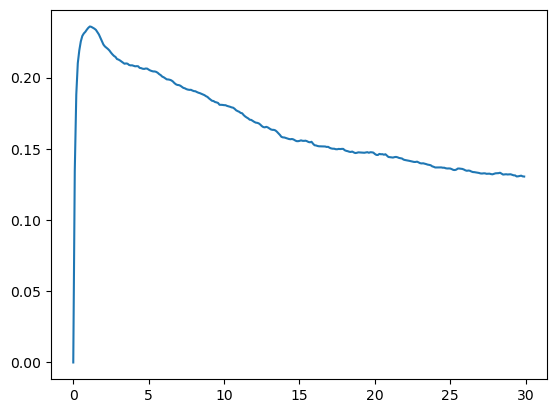

In [ ]:
s_avg = np.sqrt(history_Qxx**2 + history_Qxy**2).mean(axis=1)
plt.plot(np.arange(len(s_avg))*save_period*dt, s_avg)

In [ ]:
#from scipy.stats import binned_statistic_2d
#statistic, x_edges, y_edges,_ = binned_statistic_2d(r[:,0], r[:,1], np.sqrt(Qxx**2 + Qxy**2), bins=20)
#plt.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, statistic.T, levels=100)
#plt.show()

In [ ]:
for i in range(len(history_r)):
    fig, ax = plt.subplots(figsize=(6,6))
    plot_ellipses_exp2Q(history_r[i], history_Qxx[i], history_Qxy[i], draw_director=False, color_by_s=True, ax=ax, s_min=0, s_max=np.sqrt((history_Qxx**2 + history_Qxy**2).max()))
    ax.set_title(f"Step {i*save_period}")
    plt.savefig(f"videos/ellipse_step_{i*save_period:06d}.png", dpi=150)
    plt.close(fig)